In [61]:
using CairoMakie
using JLD2
using Oceananigans
using Statistics
using CurveFit
using ImageFiltering: imfilter, Kernel.gaussian
include("src/parameters.jl")
include("src/filament_state.jl")

Ri_min (generic function with 1 method)

In [2]:
runnames = ["Ro08Ri000Ek0A15", "Ro08Ri001Ek0A15_1", "Ro08Ri010Ek0A15", "Ro08Ri020Ek0A15"]
runtitles = [L"0.0", L"0.01", L"0.1", L"0.2"];

In [40]:
sp = create_simulation_parameters(; Ro=0.8, Ri=0.01, α=1.5)
(b₀, v₀) = get_filament_state(sp)
xs = range(-5sp.L, 5sp.L, 1024)
zs = range(-sp.H, 0, 512);

┌ Info: Created simulation parameters
│ Input:
│  Ro=0.8
│  Ri=0.01
│  Ek=0
│  α=1.5
│  λ=0.05
│  δ=-0.25
│  β=0.1
│ Output:
│  L=1
│  f=1
│  H=0.1
│  δH=-0.025
│  N₀=47.677643892862804
│  Nb=1.1356699895745754
│  ℓ=1.5
│  ν=0.0
│  Lz=0.25
│  κ=0.0
└  B₀=0.0
[ Info: Filament state created: Ro=1.8532731708566212, Ro_min=0.7999991463550904, Fr₀=0.038870905093824286, Frb=1.6318765027425455, Ri_min=0.010177366052525266


In [84]:
@inline function VSP_with_depth(runname; resolution=(600, 400))
    foldername = "../scratch/filament-instability/$runname"
    vfilename = "down_front.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:end-1], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]

    function ∂z(v)
        let a = (circshift(v, (0, -1)) - circshift(v, (0, 1))) ./ (2Δzᵃᵃᶜ)
            a[:, 1] .= 0
            a[:, end] .= 0
            a
        end
    end
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    vfile = jldopen("$foldername/$vfilename")
    file = jldopen("$foldername/$filename")
    fieldnames = [L"\partial_z \langle w'v'\rangle", "VSP", L"F_\psi"]
    function vwFLUX(frame)
        (vfile["timeseries/vwFLUX/$frame"][:, 1, 1:length(zᵃᵃᶜ)] .+ vfile["timeseries/vwFLUX/$frame"][:, 1, 2:length(zᵃᵃᶜ)+1]) / 2
    end
    
    function VSP(frame)
        return cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2) .* ∂z(file["timeseries/v_dfm/$frame"][:, 1, :])
    end
    function ψforcing(frame)
        sp.f * cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2)
    end
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    
    data = map(frames) do frame
        fields = [-vwFLUX(frame)[1:512, :], VSP(frame)[1:512, :], ψforcing(frame)[1:512, :]]
        [Δx * sum(field, dims=1)[1, :] for field in fields]
    end
    plot_data = [[data[i][f][j] for i in 1:length(frames), j in 1:length(zᵃᵃᶜ)] for f in 1:length(data[1])]
    title = "Ro=$(round(sp.Ro; digits=1)), Ri=$(round(sp.Ri; digits=2)), Ek=$(round(sp.Ek; digits=1))"

    axis_kwargs = (; xlabel="t", ylabel="z", title, limits=(ts[1], ts[end], -0.12, 0))
    return map(enumerate(plot_data)) do (i, data)
        fig = Figure(; resolution)
        ax = Axis(fig[1, 1]; axis_kwargs...)
        ht = heatmap!(ax, ts, zᵃᵃᶜ, data; colorrange=(-maximum(abs.(data)), maximum(abs.(data))), colormap=:balance)
        Colorbar(fig[1, 2], ht; label=fieldnames[i])
        fig
    end
end

VSP_with_depth (generic function with 1 method)

In [90]:
fignames = ["vwFLUX", "VSP", "psiforcing"];
for runname in runnames
    figures = VSP_with_depth(runname)
    [save("output/figures/$figname$runname.png", fig) for (fig, figname) in zip(figures, fignames)];
end

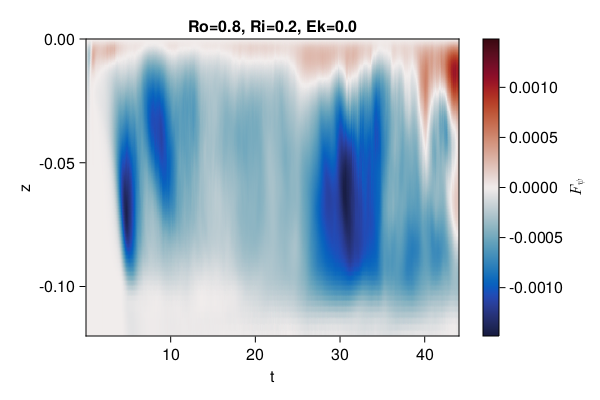

In [223]:
figures[3]

In [19]:
@inline function fit_VSP(runname, tmax)
    foldername = "../scratch/filament-instability/$runname"
    vfilename = "down_front.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:1101], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]

    function ∂z(v)
        let a = (circshift(v, (0, -1)) - circshift(v, (0, 1))) ./ (2Δzᵃᵃᶜ)
            a[:, 1] .= 0
            a[:, end] .= 0
            a
        end
    end
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    vfile = jldopen("$foldername/$vfilename")
    file = jldopen("$foldername/$filename")
    function vwFLUX(frame)
        (vfile["timeseries/vwFLUX/$frame"][:, 1, 1:length(zᵃᵃᶜ)] .+ vfile["timeseries/vwFLUX/$frame"][:, 1, 2:length(zᵃᵃᶜ)+1]) / 2
    end
    
    function VSP(frame)
        return cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2) .* ∂z(file["timeseries/v_dfm/$frame"][:, 1, :])
    end
    function ψforcing(frame)
        sp.f * cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2)
    end
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    
    ψ_fit(t) = t < tmax ? 1 : 0
    VSP_fit(t) = t < tmax ? 1 : 0
    vwFLUX_fit(t) = t < tmax ? 1 : 0
    
    # Now add up the contributions
    δψ = sum(map(zip(frames, ts)) do (frame, t)
        ψforcing(frame) * ψ_fit(t) * (ts[2] - ts[1])
            end) / sum(ψ_fit.(ts))
    
    δVSP = sum(map(zip(frames, ts)) do (frame, t)
        VSP(frame) * VSP_fit(t) * (ts[2] - ts[1])
            end) / sum(VSP_fit.(ts))
    
    δvwFLUX = sum(map(zip(frames, ts)) do (frame, t)
        vwFLUX(frame) * vwFLUX_fit(t) * (ts[2] - ts[1])
            end) / sum(VSP_fit.(ts))
    
    return (xᶜᵃᵃ, zᵃᵃᶜ, δVSP, δψ, δvwFLUX)
end

fit_VSP (generic function with 1 method)

In [41]:
(xs, zs, δVSP, δψ, δvwFLUX) = fit_VSP(runnames[2], 5);

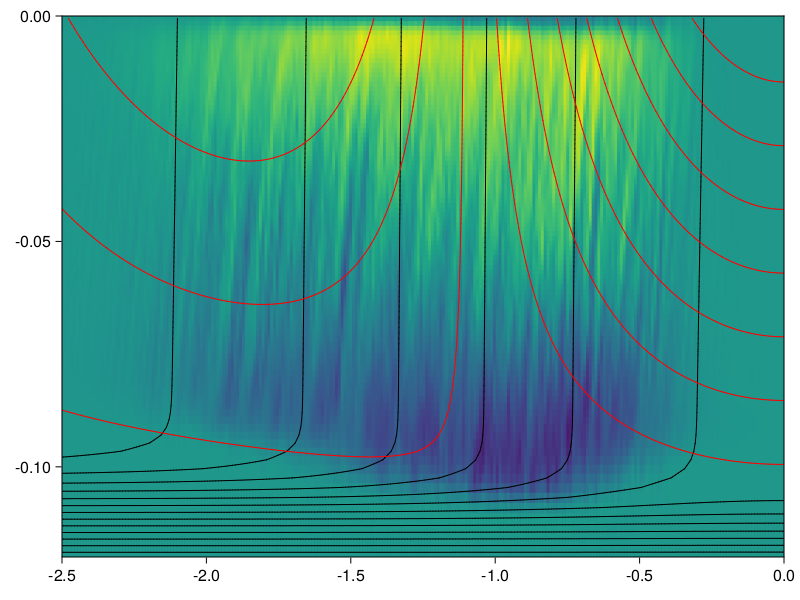

In [56]:
∂xv₀(x, z) = (v₀(x+1e-5, z) - v₀(x-1e-5, z)) / 2e-5
fig = Figure()
ax = Axis(fig[1, 1], limits = (-2.5, 0, -0.12, 0))
heatmap!(ax, xs, zs, δvwFLUX)
contour!(ax, xs, zs, b₀; color=:black, levels=100)
contour!(ax, xs, zs, ∂xv₀; color=:red, levels=10)
fig

In [88]:
σs = 0:20:400
ωs = map(σs) do σ
    a = imfilter(δvwFLUX, gaussian((σ, 0)), "circular")
    K = imfilter([(1 + ∂xv₀(x, z) / sp.f) for x in xs, z in zs], gaussian((σ, 0)), "circular")
    ω = sqrt(sum(K .* a) / sum(a)) * sp.f
end

21-element Vector{Float64}:
 0.3412201284600697
 0.3386136034417139
 0.409464630384281
 0.578512988475575
 0.7514622458827046
 0.8772090696202571
 0.9533796213000675
 0.9938947651199015
 1.0120016660324596
 1.0168078167185122
 1.0149952370937843
 1.0113990831487838
 1.0081835239662351
 1.005711798501777
 1.0037973852707667
 1.0021937663746041
 1.0010270199072513
 1.0004057518613156
 1.0001404536682132
 1.000046773135544
 1.0000319285703818

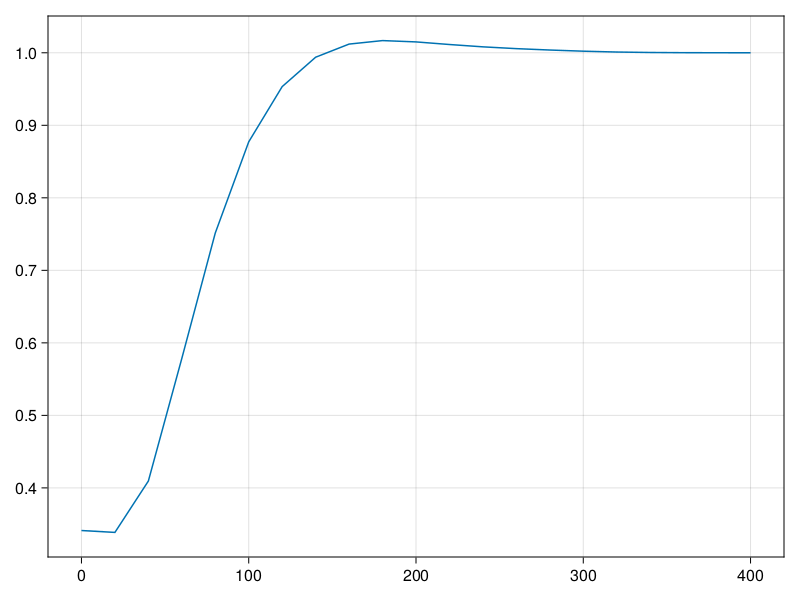

In [89]:
lines(σs, ωs)

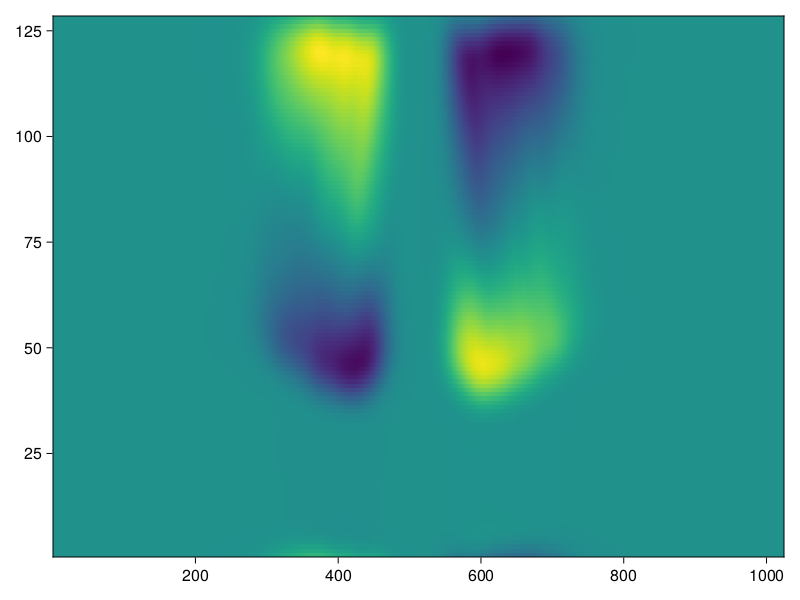

In [78]:
heatmap(imfilter(δvwFLUX, gaussian((10, 4)), "circular"))

In [3]:
@inline function total_pv(runname; resolution=(600, 400))
    foldername = "../scratch/filament-instability/$runname"
    vfilename = "down_front.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:end-1], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]

    function qᶜᶜᶜ(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
        ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)
        
        ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]
        
        ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
        return (∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ
    end
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    file = jldopen("$foldername/$filename")
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    v = file["timeseries/v_dfm/$(frames[1])"][:, 1, :]
    b = file["timeseries/b_dfm/$(frames[1])"][:, 1, :]
    low_q_region = qᶜᶜᶜ(v, b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ) .< 0
     
    data = map(frames) do frame
        v = file["timeseries/v_dfm/$frame"][:, 1, :]
        b = file["timeseries/b_dfm/$frame"][:, 1, :]
        sum(qᶜᶜᶜ(v, b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)[low_q_region] .* Δzᵃᵃᶜ .* Δx)
    end
    close(file)
    return data
    title = "Ro=$(round(sp.Ro; digits=1)), Ri=$(round(sp.Ri; digits=2)), Ek=$(round(sp.Ek; digits=1))"

    axis_kwargs = (; xlabel="t", ylabel="z", title, limits=(ts[1], ts[end], -0.12, 0))
    return map(enumerate(plot_data)) do (i, data)
        fig = Figure(; resolution)
        ax = Axis(fig[1, 1]; axis_kwargs...)
        ht = heatmap!(ax, ts, zᵃᵃᶜ, data; colorrange=(-maximum(abs.(data)), maximum(abs.(data))), colormap=:balance)
        Colorbar(fig[1, 2], ht; label=fieldnames[i])
        fig
    end
    close(file)
end

total_pv (generic function with 1 method)

In [9]:
data = total_pv.(runnames)

4-element Vector{Vector{Float64}}:
 [-7078.677113783014, -7074.739373001714, -7071.014239661734, -7067.424802975667, -7063.919826116611, -7060.437107825615, -7056.898769914793, -7053.2446614895, -7049.571531696791, -7045.836847008599  …  19368.895894381814, 19375.337669890163, 19381.87025373878, 19388.533716642807, 19395.219159635475, 19401.811428655958, 19408.407292575102, 19415.120480806767, 19421.920469091194, 19428.78798855452]
 [-6911.993161668221, -6908.218010299921, -6904.665107185198, -6901.261447107601, -6897.966185647547, -6894.733791241264, -6891.509306823631, -6888.264283685075, -6885.057175164495, -6881.863274231526  …  13411.00243819361, 13419.047847860202, 13427.057913943023, 13435.022941877804, 13442.985385198699, 13450.9293656095, 13458.864314989041, 13466.816546914684, 13474.722294131543, 13482.578404732252]
 [-5770.1398961575915, -5767.203001664766, -5764.380933115666, -5761.634839865144, -5758.91487823219, -5756.162406370511, -5753.298844582274, -5750.281043142234, 

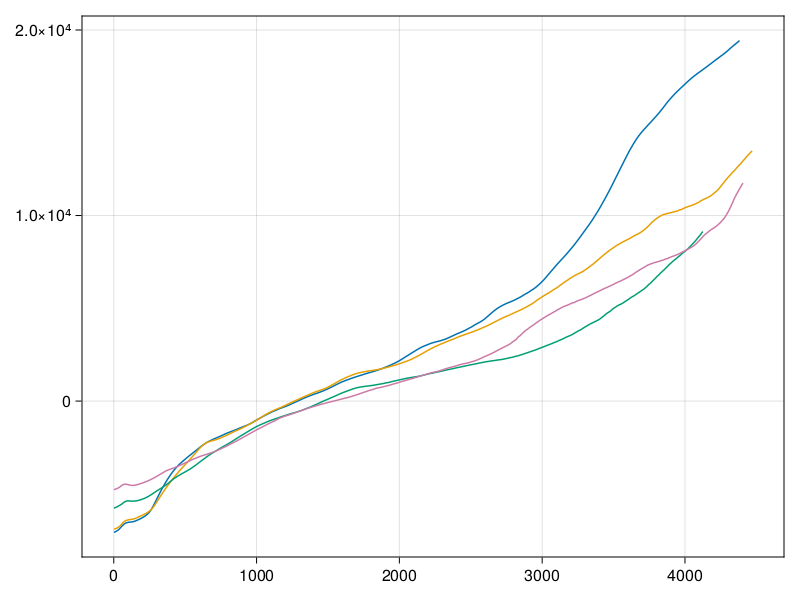

In [10]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!.(ax, data)
fig